In [1]:
import pandas as pd
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords, words, wordnet
from nltk.lm import Vocabulary
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import concurrent.futures
from torch.optim import Adam
from data_loading import process_text_df, NewsText, tensorize_sentences, collate_fn
from tqdm.notebook import tqdm
from models import NewsNet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import matplotlib.pyplot as plt
stopwords = stopwords.words()
words = words.words() 
wordnet = wordnet.words()

In [2]:
fake, true = pd.read_csv('Fake.csv'), pd.read_csv('True.csv')
fake['label'] = 'fake'
true['label'] = 'true'
news = pd.concat((fake, true))
news = news.sample(frac=1)
news.reset_index(inplace=True, drop=True)

In [3]:
p1 = process_text_df(news, ['title', 'text'])

In [4]:
%%time
p1.process_text_col()

CPU times: user 3.37 s, sys: 1.47 s, total: 4.84 s
Wall time: 4min 34s


In [5]:
p1.df

,title,text,subject,date,label
0,"[meryl, streep, probabl, forgot, time, obama, ...","[streep, shame, attempt, paint, trump, heartle...",left-news,"Jan 10, 2017",fake
1,"[risk, deeper, involv, us, weigh, option, afgh...","[washington, reuter, , presid, donald, trump, ...",politicsNews,"April 27, 2017",true
2,"[obama, sander, meet, white, hous, wednesday, ...","[washington, reuter, , presid, barack, obama, ...",politicsNews,"January 27, 2016",true
3,"[talk, seek, secur, islam, state, withdraw, ra...","[issa, syria, reuter, , remain, islam, state, ...",worldnews,"October 14, 2017",true
4,"[franc, presid, threw, awesom, shade, trump, p...","[french, presid, emmanuel, macron, wast, time,...",News,"June 2, 2017",fake
...,...,...,...,...,...
44893,"[japan, air, forc, drill, us, bomber, stealth,...","[tokyo, reuter, , japanes, f15, fighter, tuesd...",worldnews,"December 12, 2017",true
44894,"[12, muslim, migrant, gang, rape, 13, yr, old,...","[tell, us, barack, poor, widow, orphan, strate...",politics,"Feb 9, 2016",fake
44895,"[msnbc, sourc, say, everyon, network, disturb,...","[polit, pundit, joe, scarborough, donald, trum...",News,"February 12, 2016",fake
44896,"[trump, new, york, lawyer, lead, justic, dept,...","[washington, reuter, , presid, donald, trump, ...",politicsNews,"March 17, 2017",true


In [6]:
p1.tokenize_sentences()

In [7]:
l, labs = tensorize_sentences(p1.df.text.apply(lambda sent: sent[:50]), p1.df.label)

In [8]:
net = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=2)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=1e-4, weight_decay=5e-6)
idx = len(l) // 4

l_tr, labs_tr = l[:2 * idx], labs[:2 * idx]
l_val, labs_val = l[2 * idx:3 * idx], labs[2 * idx:3 * idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
tr_set = NewsText(l_tr, labs_tr)
val_set = NewsText(l_val, labs_val)
_, val_set = enumerate(DataLoader(val_set, batch_size=len(val_set), collate_fn=collate_fn)).__next__()
val_features, val_labels, val_lens = val_set
val_labels = val_labels.unsqueeze(-1).float()
loader = DataLoader(tr_set, batch_size=8, collate_fn=collate_fn)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 50
pbar = tqdm(total=epochs)
for i in range(epochs):
    pbar.update()
    for sents, labels, lens in loader:
        net.train()
        labels = labels.float().unsqueeze(-1)
        out = net(sents, lens)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net.eval()
    with torch.no_grad():
        val_out = net(val_features, val_lens)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
    pbar.set_description(desc=f'Completed {i} out of {epochs}')
    loss_list.append(loss.item())

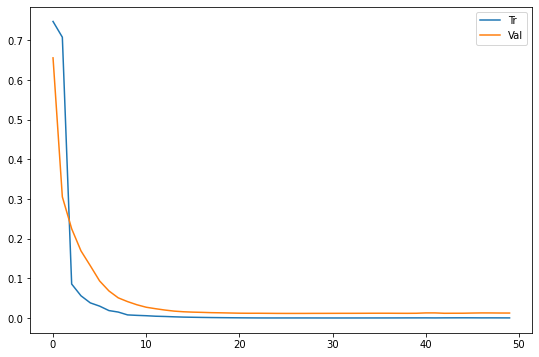

In [9]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

In [10]:
tst_set = NewsText(l_tst, labs_tst)
_, tst_set = enumerate(DataLoader(tst_set, batch_size=len(tst_set), collate_fn=collate_fn)).__next__()
tst_features, tst_labels, test_lens = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [11]:
with torch.no_grad():
    tst_out = net(tst_features, test_lens)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [13]:
accuracy_tst

0.9982830286026001